# Emotion Recognition in Persian Speech Using HuBERT

In [1]:
! nvidia-smi

Fri Jan  5 17:42:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -a ~/

.   .bashrc  .config   .jupyter  .launchpadlib	.npm	  .tmux.conf
..  .cache   .ipython  .keras	 .local		.profile  .wget-hsts


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle_api_key/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [ ]:
! kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database

 96% 796M/829M [00:07<00:00, 311MB/s]
100% 829M/829M [00:07<00:00, 116MB/s]


In [ ]:
! unzip shemo-persian-speech-emotion-detection-database.zip -d "/content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A22.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A23.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A24.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A25.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A26.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A27.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A28.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A29.tra  
  inflating: /content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/transcript/final script/F24A30.t

In [3]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Data_DL_CA_05_Q1/"

## Import and Install Libraries

In [4]:
! pip install pydub
! pip install datasets
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [83]:
import os
import numpy as np
import pandas as pd
import librosa
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
import IPython.display as ipd
from sklearn.utils import shuffle
import random
import soundfile as sf
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
from datasets import Dataset
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List, Union, Any
import torch
from transformers.file_utils import ModelOutput
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.models.hubert.modeling_hubert import (
    HubertPreTrainedModel,
    HubertModel
)
import transformers
from transformers import EvalPrediction
from transformers import TrainingArguments
import shutil
import accelerate

from packaging import version
from torch import nn

from transformers import (
    Trainer,
)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Prepare Data

In [6]:
short_2_long_emo = {'S': 'sadness', 'A': 'anger', 'H': 'happiness', 'W': 'surprise', 'F': 'fear', 'N': 'neutral'}
long_2_short_emo = {'sadness': 'S', 'anger': 'A', 'happiness': 'H', 'surprise': 'W', 'fear': 'F', 'neutral': 'N'}

In [7]:
file_names = []
file_paths = []
speakers = []
speaker_codes = []
emotions = []

In [8]:
for speaker_type in ['male', 'female']:
    speaker_directory = os.path.join(data_dir, speaker_type)
    for audio_file in os.listdir(speaker_directory):
        if audio_file.endswith(".wav"):
            path = os.path.join(speaker_directory, audio_file)
            file_names.append(audio_file)
            file_paths.append(path)
            speakers.append('M' if speaker_type == 'male' else 'F')
            speaker_codes.append(audio_file[1:3])
            emotions.append(short_2_long_emo[audio_file[3]])

In [9]:
data = pd.DataFrame({
    'file_name': file_names,
    'file_path': file_paths,
    'speaker': speakers,
    'speaker_code': speaker_codes,
    'emotion': emotions
})

### Data Information and Visualization

In [10]:
data

,file_name,file_path,speaker,speaker_code,emotion
0,M21A02.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,21,anger
1,M21N07.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,21,neutral
2,M22N12.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,22,neutral
3,M22N03.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,22,neutral
4,M22A03.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,22,anger
...,...,...,...,...,...
2995,F06H07.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,F,06,happiness
2996,F06H06.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,F,06,happiness
2997,F07A13.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,F,07,anger
2998,F06S01.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,F,06,sadness


In [11]:
data.describe()

,file_name,file_path,speaker,speaker_code,emotion
count,3000,3000,3000,3000,3000
unique,3000,3000,2,56,6
top,M21A02.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,M,12,anger
freq,1,1,1737,208,1059


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     3000 non-null   object
 1   file_path     3000 non-null   object
 2   speaker       3000 non-null   object
 3   speaker_code  3000 non-null   object
 4   emotion       3000 non-null   object
dtypes: object(5)
memory usage: 117.3+ KB


In [13]:
print("Labels: ", data["emotion"].unique())

Labels:  ['anger' 'neutral' 'surprise' 'sadness' 'happiness' 'fear']


In [14]:
emotion_distribution = data['emotion'].value_counts()
emotion_distribution

anger        1059
neutral      1028
sadness       449
surprise      225
happiness     201
fear           38
Name: emotion, dtype: int64

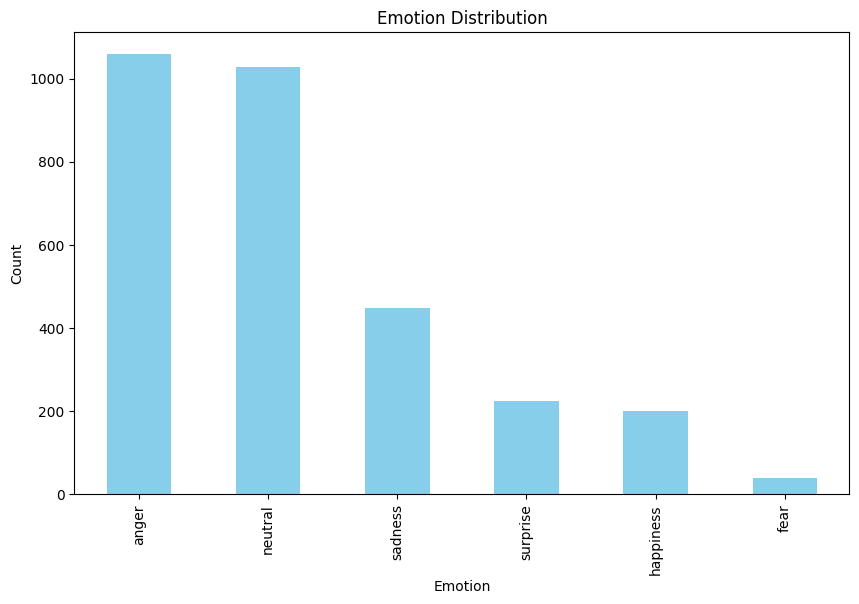

In [15]:
plt.figure(figsize=(10, 6))
emotion_distribution.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

### Grab and Play a Random Data

In [16]:
def play_random_data(data):
    idx = np.random.randint(0, len(data))
    sample = data.iloc[idx]
    path = sample["file_path"]
    label = sample["emotion"]

    print(f"ID Location: {idx}")
    print(f"      Label: {label}")
    print()

    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), orig_sr=sr, target_sr=16000)
    return ipd.Audio(data=np.asarray(speech), autoplay=False, rate=16000)

In [17]:
play_random_data(data)

ID Location: 1464
      Label: anger



### Data Augmentation

In [18]:
augmented_dir = os.path.join(data_dir, "augmented")

In [19]:
os.makedirs(augmented_dir, exist_ok=True)

In [70]:
def time_stretching(file_path, rate):
    audio, sr = librosa.load(file_path)
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    return stretched, sr

def pitch_shifting(file_path, n_steps):
    audio, sr = librosa.load(file_path)
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return shifted, sr

def add_background_noise(file_path, noise_factor):
    audio, sr = librosa.load(file_path)
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio, sr

In [28]:
def augment_data(files_path, emotion, n_target):

    n_current = len(files_path)
    n_augment = (n_target - n_current) // 3
    file_ind = 0

    for i in range(n_augment):
        file_path = files_path[file_ind % n_current]
        file_ind += 1

        rate = random.uniform(0.8, 1.2)
        stretched_audio, sr = time_stretching(file_path, rate)
        stretched_file_path = os.path.join(augmented_dir, f"{emotion}_{i}_stretched.wav")
        sf.write(stretched_file_path, stretched_audio, sr)

        n_steps = random.randint(-3, 3)
        shifted_audio, sr = pitch_shifting(file_path, n_steps)
        shifted_file_path = os.path.join(augmented_dir, f"{emotion}_{i}_shifted.wav")
        sf.write(shifted_file_path, shifted_audio, sr)

        noise_factor = np.random.uniform(0.001, 0.005)
        noisy_audio, sr = add_background_noise(file_path, noise_factor)
        noisy_file_path = os.path.join(augmented_dir, f"{emotion}_{i}_noisy.wav")
        sf.write(noisy_file_path, noisy_audio, sr)


In [25]:
def remove_files(directory, format):
  for file_name in os.listdir(directory):
    if file_name.endswith(".wav"):
      file_path = os.path.join(directory, file_name)
      os.remove(file_path)

In [26]:
if os.listdir(augmented_dir):
  print('Augmented data found. Do you want to remove them? [y/n]')
  ans = input()
  if ans == 'y':
    remove_files(augmented_dir, '.wav')

In [29]:
if not os.listdir(augmented_dir):
  for emotion in ['fear', 'happiness', 'surprise', 'sadness']:
    files_path = data.loc[data['emotion'] == emotion, ['file_path']]['file_path'].tolist()
    augment_data(files_path, long_2_short_emo[emotion], 1000)

In [30]:
aug_names = []
aug_paths = []
aug_emotions = []

In [31]:
for audio_file in os.listdir(augmented_dir):
  if audio_file.endswith(".wav"):
    path = os.path.join(augmented_dir, audio_file)
    aug_names.append(audio_file)
    aug_paths.append(path)
    aug_emotions.append(short_2_long_emo[audio_file[0]])

In [32]:
aug_data = pd.DataFrame({
    'file_name': aug_names,
    'file_path': aug_paths,
    'emotion': aug_emotions
})

In [33]:
aug_data

,file_name,file_path,emotion
0,F_0_stretched.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,fear
1,F_0_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,fear
2,F_0_noisy.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,fear
3,F_1_stretched.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,fear
4,F_1_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,fear
...,...,...,...
3076,S_181_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
3077,S_181_noisy.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
3078,S_182_stretched.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
3079,S_182_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness


#### Grab and Play a Random Augmented Data

In [34]:
play_random_data(aug_data)

ID Location: 678
      Label: fear



In [35]:
combined_data = data[['file_name', 'file_path', 'emotion']]

In [36]:
combined_data = data[['file_name','file_path','emotion']]
combined_data = pd.concat([combined_data, aug_data]).reset_index(drop=True)
combined_data

,file_name,file_path,emotion
0,M21A02.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,anger
1,M21N07.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,neutral
2,M22N12.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,neutral
3,M22N03.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,neutral
4,M22A03.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,anger
...,...,...,...
6076,S_181_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
6077,S_181_noisy.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
6078,S_182_stretched.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness
6079,S_182_shifted.wav,/content/drive/MyDrive/Colab Notebooks/Data_DL...,sadness


In [37]:
combined_distribution = combined_data['emotion'].value_counts()

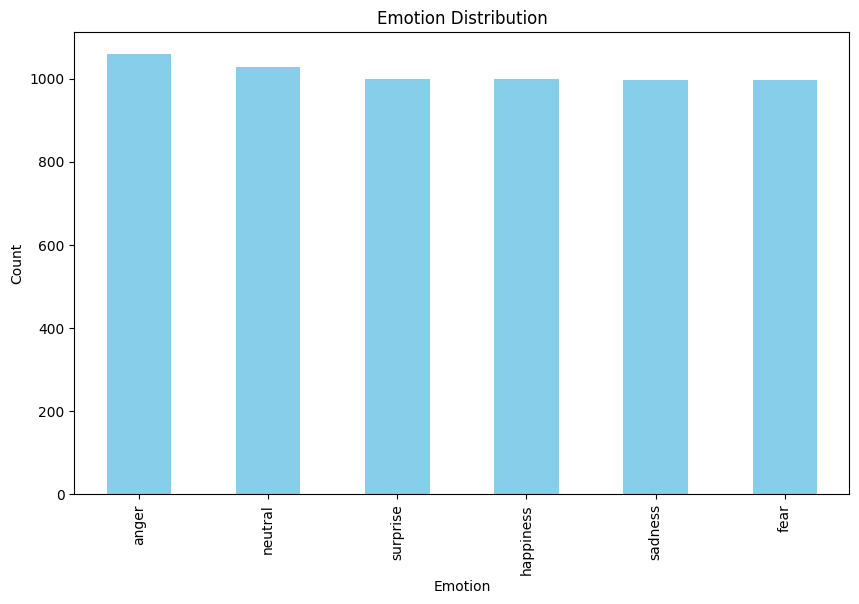

In [38]:
plt.figure(figsize=(10, 6))
combined_distribution.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

### Data Split

In [40]:
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42, stratify=combined_data['emotion'])
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42, stratify=test_data['emotion'])

In [41]:
train_emotion_distribution = train_data['emotion'].value_counts()

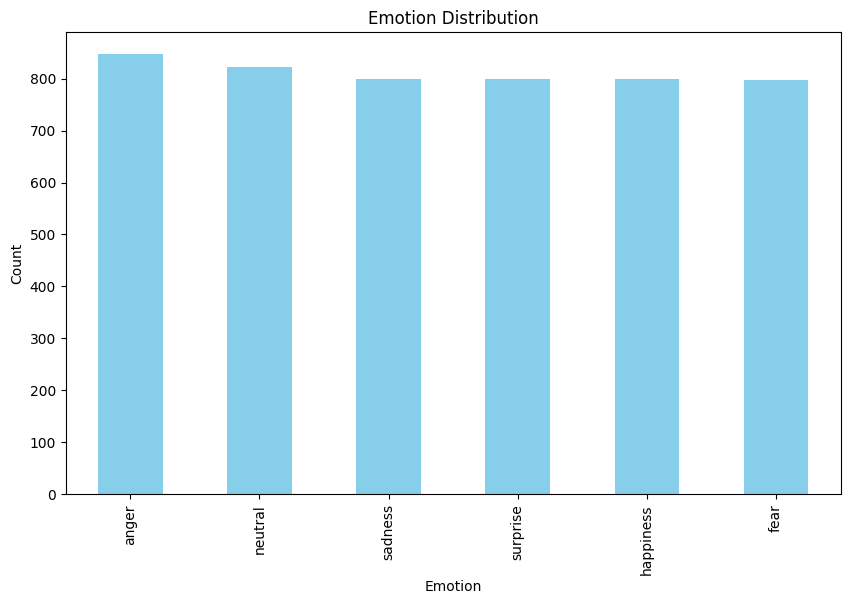

In [42]:
plt.figure(figsize=(10, 6))
train_emotion_distribution.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [43]:
train_dataset = Dataset.from_pandas(train_data[['file_path', 'emotion']])
val_dataset = Dataset.from_pandas(val_data[['file_path', 'emotion']])
test_dataset = Dataset.from_pandas(test_data[['file_path', 'emotion']])

### Preprocessing

In [44]:
input_col = "file_path"
target_col = "emotion"

In [45]:
label_list = train_dataset.unique(target_col)
label_list.sort()
n_labels = len(label_list)
print(f"A classification problem with {n_labels} classes: {label_list}")

A classification problem with 6 classes: ['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [46]:
model_name_or_path = "facebook/hubert-base-ls960"
pooling_mode = "mean"

In [47]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=n_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)

setattr(config, 'pooling_mode', pooling_mode)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

In [48]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate

print(f"The target sampling rate: {target_sampling_rate}")

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

The target sampling rate: 16000


In [49]:
def speech_file_to_array(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def preprocessor(samples):
    speech_list = [speech_file_to_array(path) for path in samples[input_col]]
    target_list = [label_to_id(label, label_list) for label in samples[target_col]]

    result = feature_extractor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [50]:
batch_size = 2

train_dataset = train_dataset.map(
    preprocessor,
    batch_size=batch_size,
    batched=True,
    num_proc=4
)

val_dataset = val_dataset.map(
    preprocessor,
    batch_size=batch_size,
    batched=True,
    num_proc=4
)

test_dataset = test_dataset.map(
    preprocessor,
    batch_size=batch_size,
    batched=True,
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/4864 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/609 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/608 [00:00<?, ? examples/s]

In [51]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [0.04426838830113411, 0.06600534170866013, 0.06121945381164551, 0.06793315708637238, 0.0656253919005394, 0.0703371912240982, 0.06632078438997269, 0.07049984484910965, 0.07104846835136414, 0.0643569752573967, 0.06724917143583298, 0.07060167193412781, 0.07100186496973038, 0.07562217116355896, 0.0735047236084938, 0.07493267953395844, 0.07505837827920914, 0.0685529112815857, 0.07268423587083817, 0.07215367257595062, 0.07347133010625839, 0.07609376311302185, 0.07815125584602356, 0.07869382947683334, 0.07673413306474686, 0.07544124871492386, 0.06996449828147888, 0.07459545880556107, 0.08083289861679077, 0.07633112370967865, 0.0773400217294693, 0.08308779448270798, 0.07730083167552948, 0.07460077106952667, 0.07971299439668655, 0.07928561419248581, 0.07884786278009415, 0.0796172246336937, 0.08269724249839783, 0.08197958767414093, 0.08000461757183075, 0.07904302328824997, 0.08471963554620743, 0.08328627049922943, 0.08727904409170151, 0.08254086226224899, 0.079654291272163

In [52]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


## Model

In [53]:
class HubertClassificationHead(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class HubertForSpeechClassification(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.hubert = HubertModel(config)
        self.classifier = HubertClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.hubert.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [54]:
@dataclass
class DataLoaderWithPadding:

    feature_extractor: Wav2Vec2FeatureExtractor

    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.feature_extractor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [55]:
data_loader = DataLoaderWithPadding(feature_extractor=feature_extractor, padding=True)

In [56]:
is_regression = False

In [57]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [58]:
model = HubertForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
model.freeze_feature_extractor()

In [60]:
drive_dir = "/content"
!ls {drive_dir}
output_dir = os.path.join(drive_dir, "ckpts", "hubert-base-greek-ser")
!ls {output_dir}

drive  sample_data
ls: cannot access '/content/ckpts/hubert-base-greek-ser': No such file or directory


In [61]:
last_checkpoint = None
checkpoints = []

if os.path.exists(output_dir):
    for subdir in os.scandir(output_dir):
        if subdir.is_dir():
            checkpoints.append(subdir.path)


if len(checkpoints) > 0:
    checkpoints = list(sorted(checkpoints, key=lambda ckpt: ckpt.split('/')[-1].split('-')[-1], reverse=True))
    model_name_or_path = os.path.join("/content", checkpoints[0].split("/")[-1])
    last_checkpoint = model_name_or_path
    shutil.copytree(checkpoints[0], model_name_or_path)

In [62]:
print(f"model_name_or_path: {model_name_or_path}")
print(f"last_checkpoint: {last_checkpoint}")

model_name_or_path: facebook/hubert-base-ls960
last_checkpoint: None


### Training

In [63]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=2.0,
    fp16=True,
    save_steps=1e12,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1e-4,
    save_total_limit=0,
    do_train=True,
    do_eval=True,
    do_predict=True
)

In [64]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_loader,
    compute_metrics=compute_metrics
)

In [65]:
def plot_metric(metric, label, y_label):
  plt.plot(metric, label=label)
  plt.xlabel("100 * Steps")
  plt.ylabel(y_label)
  plt.title(label)
  plt.legend()
  plt.show()

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [67]:
torch.cuda.empty_cache()

In [68]:
model = model.to(device)

In [69]:
print(f"last_checkpoint: {last_checkpoint}")

train_result = trainer.train(resume_from_checkpoint=last_checkpoint)

last_checkpoint: None


Step,Training Loss,Validation Loss,Accuracy
100,1.689400,1.683429,0.303777
200,1.615700,1.474214,0.310345
300,1.468800,1.417506,0.459770


Step,Training Loss,Validation Loss,Accuracy
100,1.689400,1.683429,0.303777
200,1.615700,1.474214,0.310345
300,1.468800,1.417506,0.459770
400,1.566700,1.767452,0.390805
500,1.347300,1.667449,0.492611
600,1.326700,1.811013,0.438424
700,1.384000,1.615588,0.425287
800,1.446400,1.089393,0.573071
900,1.158500,1.246141,0.592775
1000,1.281700,1.249460,0.614121


In [71]:
trainer.save_model()

feature_extractor.save_pretrained(training_args.output_dir)

metrics = train_result.metrics

metrics["train_samples"] = len(train_dataset)

trainer.log_metrics("train", metrics)

trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 309448574GF
  train_loss               =      0.9065
  train_runtime            =  1:00:11.21
  train_samples            =        4864
  train_samples_per_second =       2.694
  train_steps_per_second   =       1.347


### Results Visualization

#### Loss and Accuracy

In [72]:
train_loss = [item.get('loss', None) for item in trainer.state.log_history]
train_loss = [x for x in train_loss if x is not None]

val_loss = [item.get('eval_loss', None) for item in trainer.state.log_history]
val_loss = [x for x in val_loss if x is not None]

val_accuracy = [item.get('eval_accuracy', None) for item in trainer.state.log_history]
val_accuracy = [x for x in val_accuracy if x is not None]

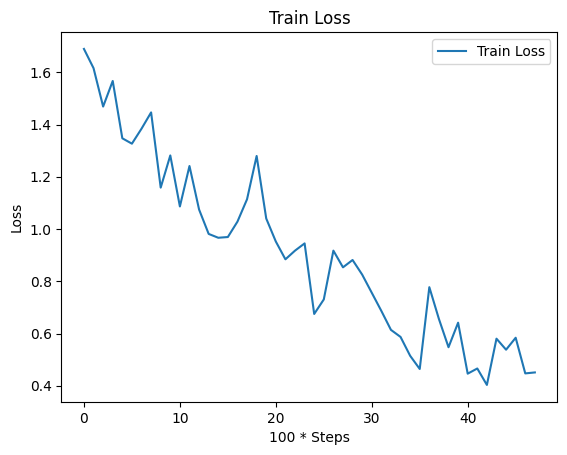

In [73]:
plot_metric(train_loss, 'Train Loss', 'Loss')

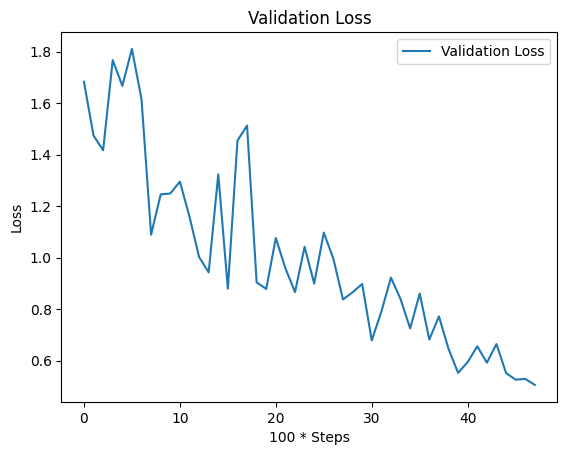

In [74]:
plot_metric(val_loss, 'Validation Loss', 'Loss')

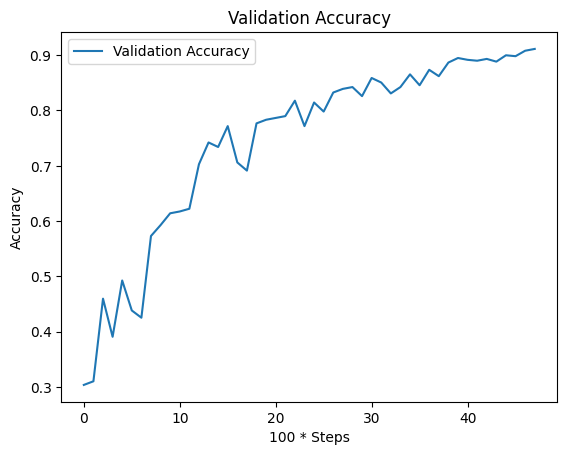

In [75]:
plot_metric(val_accuracy, 'Validation Accuracy', 'Accuracy')

In [76]:
y_train = [config.label2id[name] for name in train_dataset["emotion"]]
y_val = [config.label2id[name] for name in val_dataset["emotion"]]
y_test = [config.label2id[name] for name in test_dataset["emotion"]]

In [77]:
preds_train = trainer.predict(train_dataset).predictions
preds_val = trainer.predict(val_dataset).predictions
preds_test = trainer.predict(test_dataset).predictions

#### Classification Report

In [80]:
print(f'Train Classification Report:\n{classification_report(y_train, preds_train.argmax(axis=1))}')

Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       847
           1       0.97      1.00      0.98       798
           2       0.94      0.95      0.94       799
           3       0.88      0.95      0.91       822
           4       0.96      0.89      0.93       799
           5       0.96      0.89      0.92       799

    accuracy                           0.94      4864
   macro avg       0.94      0.94      0.94      4864
weighted avg       0.94      0.94      0.94      4864



In [81]:
print(f'Validation Classification Report:\n{classification_report(y_val, preds_val.argmax(axis=1))}')

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       106
           1       0.94      0.99      0.97       100
           2       0.92      0.86      0.89       100
           3       0.82      0.91      0.87       103
           4       0.94      0.83      0.88       100
           5       0.95      0.93      0.94       100

    accuracy                           0.91       609
   macro avg       0.91      0.91      0.91       609
weighted avg       0.91      0.91      0.91       609



In [82]:
print(f'Test Classification Report:\n{classification_report(y_test, preds_test.argmax(axis=1))}')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       106
           1       1.00      1.00      1.00       100
           2       0.89      0.92      0.91       100
           3       0.84      0.88      0.86       103
           4       0.94      0.85      0.89        99
           5       0.93      0.88      0.90       100

    accuracy                           0.91       608
   macro avg       0.92      0.91      0.91       608
weighted avg       0.91      0.91      0.91       608



#### Confusion Matrix

In [92]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    classes = label_list

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

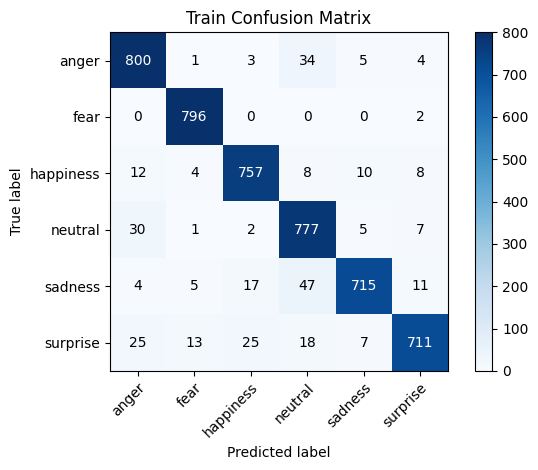

In [93]:
plot_confusion_matrix(y_train, preds_train.argmax(axis=1), title='Train Confusion Matrix')

plt.show()

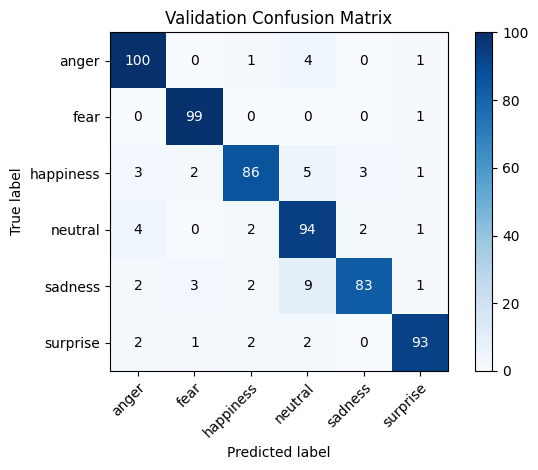

In [94]:
plot_confusion_matrix(y_val, preds_val.argmax(axis=1), title='Validation Confusion Matrix')

plt.show()

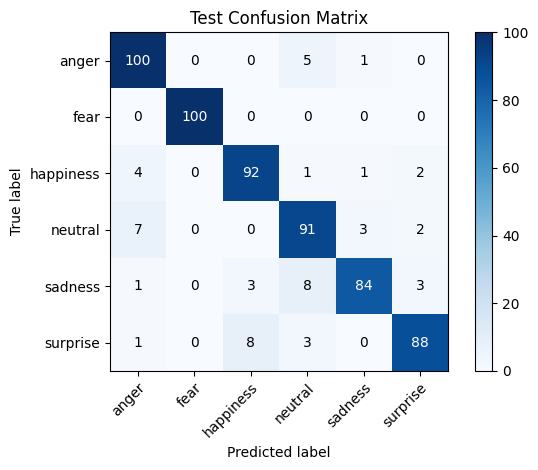

In [95]:
plot_confusion_matrix(y_test, preds_test.argmax(axis=1), title='Test Confusion Matrix')

plt.show()